In [229]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os 
import tabulate
from scipy.stats import wilcoxon, ttest_rel

from slim_gsgp_lib.datasets.data_loader import *
datasets = [globals()[i] for i in globals() if 'load' in i][2:]

#### Found 
- Ms upper of 0
- Parkinson dataset too large (> 5000 samples)

#### TODO
- Make plots for the results to check how the fitness evolves with time (train/test) + diversity with callbacks

In [385]:
dataset_names=[]
count = 0
for file in os.listdir('results/slim'):
    count += 1
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)
    
print(f'Number of datapoints: {count}')
    
num_existing = {'unscaled':0, 'unscaled_mutxo':0, 'scaled_mutxo':0, 'scaled_mutxo_strucmut':0, 
                'scaled_xo_strucmut':0, 'scaled_xo_mutxo_strucmut':0, 'scaled_xo':0, 'scaled':0, 'scaled_strucmut':0}
for dataset_name in dataset_names:
    for key in num_existing.keys():
        if os.path.exists(f'results/slim/{dataset_name}_{key}.pkl'):
            num_existing[key]+=1
        
        if 'unscaled_mutxo' in key: 
            if os.path.exists(f'results/slim/{dataset_name}_mutxo.pkl'):
                num_existing[key]+=1
            
        elif 'unscaled' in key:
            if os.path.exists(f'results/slim/{dataset_name}.pkl'):
                num_existing[key]+=1
            
num_existing

Number of datapoints: 136


{'unscaled': 15,
 'unscaled_mutxo': 15,
 'scaled_mutxo': 16,
 'scaled_mutxo_strucmut': 15,
 'scaled_xo_strucmut': 15,
 'scaled_xo_mutxo_strucmut': 15,
 'scaled_xo': 15,
 'scaled': 15,
 'scaled_strucmut': 15}

In [476]:
def get_significance(p_value, ratio):
    if p_value >= 0.05:
        return '0'
    elif ratio > 1:
        return '-' * (1 + int(p_value < 0.01) + int(p_value < 0.001))
    else:
        return '+' * (1 + int(p_value < 0.01) + int(p_value < 0.001))

def calculate_statistical_significance(prefix1, prefix2, dataset_names):
    df_stat_sign = pd.DataFrame(columns=['Dataset', 'Algorithm', 'Ratio', 'Significance_RMSE', 'Significance_Size'])
    df_stat_sign = df_stat_sign.astype({'Dataset': 'object', 'Algorithm': 'object', 'Ratio': 'float64', 'Significance_RMSE': 'object', 'Significance_Size': 'object'})

    for dataset in dataset_names:
        path_1 = f'results/slim/{dataset}_{prefix1}.pkl' if prefix1 != '' else f'results/slim/{dataset}.pkl'
        path_2 = f'results/slim/{dataset}_{prefix2}.pkl' if prefix2 != '' else f'results/slim/{dataset}.pkl'
        try: 
            with open(path_1, 'rb') as f:
                results_1 = pickle.load(f)
            
            with open(path_2, 'rb') as f:
                results_2 = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue        
        
        rmse_1 = results_1['rmse_compare']
        rmse_2 = results_2['rmse_compare']
        size_1 = results_1['size']
        size_2 = results_2['size']
        
        for algorithm in rmse_1.keys():
            rmse_1_values = rmse_1[algorithm]
            rmse_2_values = rmse_2[algorithm]
            size_1_values = size_1[algorithm]
            size_2_values = size_2[algorithm]
            
            # Wilcoxon-Test durchführen
            d_rmse = np.round(np.array(rmse_1_values) - np.array(rmse_2_values), decimals=8)
            d_size = np.round(np.array(size_1_values) - np.array(size_2_values), decimals=8)
            
            statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
            statistic_size, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
            
            rmse_1_mean = np.mean(rmse_1_values)
            rmse_2_mean = np.mean(rmse_2_values)
            ratio = rmse_1_mean / rmse_2_mean
            
            significance = get_significance(p_value, ratio)
            
            significance_size = get_significance(p_value_size, np.mean(size_1_values) / np.mean(size_2_values))
            
            new_row = pd.DataFrame({
                'Dataset': [dataset],
                'Algorithm': [algorithm],
                'Ratio': [ratio],  
                'Significance_RMSE': [significance],
                'Significance_Size': [significance_size]
            })

            df_stat_sign = pd.concat([df_stat_sign, new_row], ignore_index=True)

    # DataFrame für bessere Lesbarkeit sortieren
    df_stat_sign = df_stat_sign.sort_values(['Dataset', 'Algorithm'])
    df_stat_sign.set_index(['Dataset', 'Algorithm'], inplace=True)

    return df_stat_sign

def calculate_statistical_significance_best(prefix1, prefix2, dataset_names):
    df_stat_sign = pd.DataFrame(columns=['Dataset', 'Algorithm_1', 'Algorithm_2', 'Ratio', 'Significance_RMSE', 'Significance_Size'])
    df_stat_sign = df_stat_sign.astype({'Dataset': 'object', 'Algorithm_1': 'object', 'Algorithm_2': 'object', 'Ratio': 'float64', 'Significance_RMSE': 'object', 'Significance_Size': 'object'})

    for dataset in dataset_names:
        path_1 = f'results/slim/{dataset}_{prefix1}.pkl' if prefix1 != '' else f'results/slim/{dataset}.pkl'
        path_2 = f'results/slim/{dataset}_{prefix2}.pkl' if prefix2 != '' else f'results/slim/{dataset}.pkl'
        try: 
            with open(path_1, 'rb') as f:
                results_1 = pickle.load(f)
            
            with open(path_2, 'rb') as f:
                results_2 = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue        
        
        rmse_1 = results_1['rmse_compare']
        rmse_2 = results_2['rmse_compare']
        size_1 = results_1['size']
        size_2 = results_2['size']
        
        # Find best algorithm for each prefix
        best_algo_1 = min(rmse_1, key=lambda k: np.mean(rmse_1[k]))
        best_algo_2 = min(rmse_2, key=lambda k: np.mean(rmse_2[k]))
        
        rmse_1_values = rmse_1[best_algo_1]
        rmse_2_values = rmse_2[best_algo_2]
        size_1_values = size_1[best_algo_1]
        size_2_values = size_2[best_algo_2]
        
        # Wilcoxon-Test durchführen
        d_rmse = np.round(np.array(rmse_1_values) - np.array(rmse_2_values), decimals=8)
        d_size = np.round(np.array(size_1_values) - np.array(size_2_values), decimals=8)
        
        statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
        statistic_size, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
        
        rmse_1_mean = np.mean(rmse_1_values)
        rmse_2_mean = np.mean(rmse_2_values)
        ratio = rmse_1_mean / rmse_2_mean
        
        significance = get_significance(p_value, ratio)
        significance_size = get_significance(p_value_size, np.mean(size_1_values) / np.mean(size_2_values))
        
        new_row = pd.DataFrame({
            'Dataset': [dataset],
            'Algorithm_1': [best_algo_1],
            'Algorithm_2': [best_algo_2],
            'Ratio': [ratio],  
            'Significance_RMSE': [significance],
            'Significance_Size': [significance_size]
        })

        df_stat_sign = pd.concat([df_stat_sign, new_row], ignore_index=True)

    # DataFrame für bessere Lesbarkeit sortieren
    df_stat_sign = df_stat_sign.sort_values(['Dataset'])
    df_stat_sign.set_index('Dataset', inplace=True)

    return df_stat_sign

In [ ]:
def compare_prefixes(main_prefix, prefix_list, dataset_names):
    rmse_df = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, ['SLIM+SIG2', 'SLIM*SIG2', 'SLIM+ABS', 'SLIM*ABS', 'SLIM+SIG1', 'SLIM*SIG1']], names=['Dataset', 'Algorithm']), columns=prefix_list)
    size_df = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, ['SLIM+SIG2', 'SLIM*SIG2', 'SLIM+ABS', 'SLIM*ABS', 'SLIM+SIG1', 'SLIM*SIG1']], names=['Dataset', 'Algorithm']), columns=prefix_list)

    for dataset in dataset_names:
        main_path = f'results/slim/{dataset}_{main_prefix}.pkl' if main_prefix != '' else f'results/slim/{dataset}.pkl'
        try:
            with open(main_path, 'rb') as f:
                main_results = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue

        main_rmse = main_results['rmse_compare']
        main_size = main_results['size']
        
        for prefix in prefix_list:
            if prefix == main_prefix:
                rmse_df.loc[dataset, prefix] = '0'
                size_df.loc[dataset, prefix] = '0'
                continue
            
            comp_path = f'results/slim/{dataset}_{prefix}.pkl' if prefix != '' else f'results/slim/{dataset}.pkl'
            try:
                with open(comp_path, 'rb') as f:
                    comp_results = pickle.load(f)
            except FileNotFoundError:
                print(f'Dataset nicht verfügbar: {dataset}')
                continue

            comp_rmse = comp_results['rmse_compare']
            comp_size = comp_results['size']

            for algorithm in main_rmse.keys():
                main_rmse_values = main_rmse[algorithm]
                main_size_values = main_size[algorithm]
                comp_rmse_values = comp_rmse[algorithm]
                comp_size_values = comp_size[algorithm]

                # RMSE comparison
                d_rmse = np.round(np.array(main_rmse_values) - np.array(comp_rmse_values), decimals=8)
                _, p_value_rmse = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
                
                rmse_ratio = np.mean(comp_rmse_values) / np.mean(main_rmse_values)
                rmse_significance = get_significance(p_value_rmse, rmse_ratio)
                
                rmse_df.loc[(dataset, algorithm), prefix] = rmse_significance

                # Size comparison
                d_size = np.round(np.array(main_size_values) - np.array(comp_size_values), decimals=8)
                _, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
                
                size_ratio = np.mean(main_size_values) / np.mean(comp_size_values)
                size_significance = get_significance(p_value_size, size_ratio)
                                
                size_df.loc[(dataset, algorithm), prefix] = size_significance

    # Remove rows with NaN values
    rmse_df = rmse_df.dropna()
    size_df = size_df.dropna()
    return rmse_df, size_df

In [420]:
def create_rmse_means_dataset(prefixes, dataset_names, ignore_errors=True):
    df = pd.DataFrame()
    available_datasets = []

    for prefix in prefixes:
        for dataset in dataset_names:
            file_path = f'results/slim/{dataset}_{prefix}.pkl' if prefix else f'results/slim/{dataset}.pkl'
            
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}") if not ignore_errors else None
                continue

            with open(file_path, 'rb') as f:
                results = pickle.load(f)

            rmse_compare = results['rmse_compare']

            for algorithm, rmse_values in rmse_compare.items():
                rmse_mean = np.mean(rmse_values)
                
                new_row = pd.DataFrame({
                    'Prefix': [prefix if prefix else 'base'],
                    'Algorithm': [algorithm],
                    dataset: [rmse_mean]
                })

                df = pd.concat([df, new_row], ignore_index=True)
            
            if dataset not in available_datasets:
                available_datasets.append(dataset)

    # Pivot the DataFrame using only available datasets
    df_pivot = df.pivot_table(values=available_datasets, index=['Prefix', 'Algorithm'], aggfunc='first')
    
    # Remove columns with NaN values
    df_pivot = df_pivot.dropna(axis=1)

    return df_pivot

### Scale vs non-scale

#### Ratio of the minimum means

In [216]:
dataset_names=[]
df_ratio = pd.DataFrame()
data_mins = []
for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)

for dataset in dataset_names:
    try: 
        with open('results/slim/'+dataset+'_scaled.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open('results/slim/'+dataset+'.pkl', 'rb') as f:
            results_unscaled = pickle.load(f)
    except:
        print('Dataset not available:', dataset)
        continue        
    
    # Get the dataset 
    X, y = [i for i in datasets if dataset in i.__name__][0]()
    # Get the scale of the dataset
    scale = pd.DataFrame(X).mean()
    scale_X = scale.mean()
    scale_y = y.mean().item()
    scale_diff = np.abs(np.log(0.0001+(scale_X/scale_y)))
    scale_std = scale.std()
    
    rmse_scaled = results_scaled['rmse_compare']
    rmse_unscaled = results_unscaled['rmse_compare']
       
    rmse_scaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_scaled.items()])
    rmse_unscaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_unscaled.items()])

    rmse_ratio = rmse_scaled_means/rmse_unscaled_means
    rmse_ratio_min = rmse_scaled_means.min()/rmse_unscaled_means.min()
    
    df_ratio_temp = pd.DataFrame(rmse_ratio, columns=[dataset])
    df_ratio = pd.concat([df_ratio, df_ratio_temp], axis=1)
    data_mins.append((dataset, rmse_ratio_min, scale_diff, scale_std))
    
# Change the index to results_scaled['rmse_compare'].keys()
df_ratio.index = list(results_scaled['rmse_compare'].keys())
df_mins = pd.DataFrame(data_mins, columns=['Dataset', 'Min ratio', 'Scale diff', 'Scale std'])
df_mins.set_index('Dataset', inplace=True)

Dataset not available: parkinson_updrs


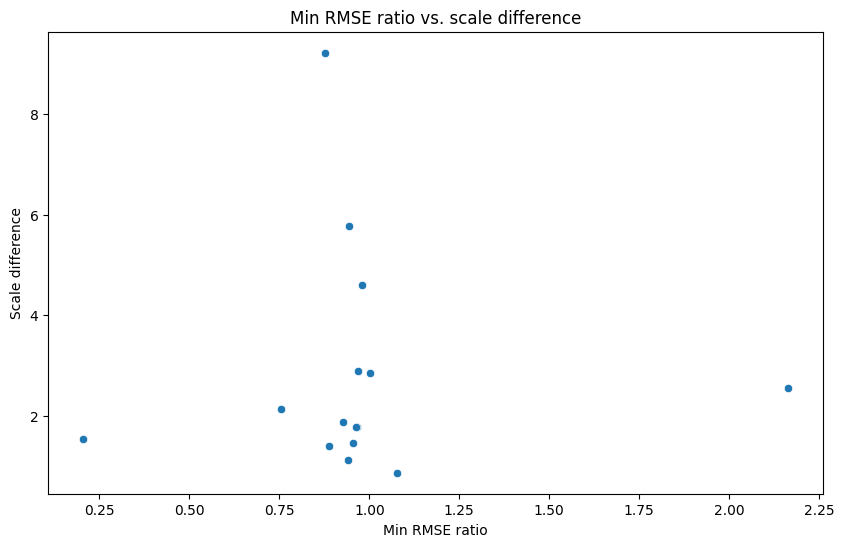

In [223]:
# Scatter plot of the ratio of scaled to unscaled RMSE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mins, x='Min ratio', y='Scale diff')
plt.ylabel('Scale difference')
plt.xlabel('Min RMSE ratio')
plt.title('Min RMSE ratio vs. scale difference')
plt.show()

In [224]:
df_ratio

,airfoil,bike_sharing,bioav,boston,breast_cancer,concrete_slump,concrete_strength,diabetes,efficiency_cooling,efficiency_heating,forest_fires,istanbul,ld50,ppb,resid_build_sale_price
SLIM+SIG2,0.120323,0.850235,0.619006,0.600838,0.967538,0.831929,0.327296,0.394614,0.490788,0.416295,0.920183,1.129205,0.901803,1.005746,0.606627
SLIM*SIG2,0.219730,0.873238,0.852894,1.162565,1.178383,1.008108,0.628596,0.793224,1.184631,1.434578,1.102664,0.971205,2.341619,1.131986,0.970793
SLIM+ABS,0.118064,0.655430,0.693199,0.699765,1.044030,0.785949,0.525032,0.388551,0.490608,0.554514,0.623390,1.070273,0.883269,0.873620,0.608143
SLIM*ABS,0.250768,2.163475,0.881227,1.131885,1.219993,1.031829,0.696963,0.847636,1.214435,1.432471,0.933277,1.034844,1.349962,1.205168,0.969405
SLIM+SIG1,0.107271,0.455317,0.702940,0.721475,1.032420,0.993029,0.477481,0.412490,0.667698,0.683866,1.106550,1.269533,0.935042,0.911821,0.536001
SLIM*SIG1,0.258100,2.870549,0.900988,1.123700,0.996706,0.877188,0.843301,0.890517,1.149634,1.279006,1.049797,1.049654,0.877822,0.961976,0.968973


In [225]:
df_mins

,Min ratio,Scale diff,Scale std
Dataset,,,
airfoil,0.205210,1.551166,1.284542e+03
bike_sharing,2.163472,2.560018,1.021231e+03
bioav,0.886675,1.413954,1.527147e+02
boston,0.939529,1.134611,1.401351e+02
breast_cancer,0.979423,4.591516,1.958614e+02
concrete_slump,0.969696,2.895665,3.420191e+02
concrete_strength,0.754421,2.135987,3.694190e+02
diabetes,0.875817,9.210340,1.490847e-10
efficiency_cooling,0.966649,1.791065,2.420173e+02


#### Statistical significance

In [508]:
calculate_statistical_significance_best('scaled', '', dataset_names)

Dataset nicht verfügbar: parkinson_updrs


,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
airfoil,SLIM+SIG1,SLIM*ABS,0.205210,+++,---
bike_sharing,SLIM+SIG1,SLIM*SIG1,2.163472,---,0
bioav,SLIM*ABS,SLIM*SIG1,0.886675,+++,+++
boston,SLIM+SIG2,SLIM*ABS,0.939529,0,---
breast_cancer,SLIM+SIG2,SLIM+ABS,0.979423,0,---
concrete_slump,SLIM+ABS,SLIM*ABS,0.969696,0,++
concrete_strength,SLIM+SIG2,SLIM*SIG1,0.754421,+++,---
diabetes,SLIM+SIG1,SLIM*SIG1,0.875817,++,+++
efficiency_cooling,SLIM+SIG2,SLIM*SIG1,0.966649,0,0


In [479]:
df_stat_sign = calculate_statistical_significance('scaled', '', dataset_names)
print(df_stat_sign['Significance_RMSE'].value_counts())
print(df_stat_sign['Significance_Size'].value_counts())

Dataset nicht verfügbar: parkinson_updrs
Significance_RMSE
+++    45
0      17
---    14
+       4
--      4
-       3
++      3
Name: count, dtype: int64
Significance_Size
+++    50
---    23
0       9
-       3
+       2
++      2
--      1
Name: count, dtype: int64


In [480]:
df_stat_sign[['Ratio', 'Significance_RMSE']].head(20)

Ratio Significance_RMSE
Dataset      Algorithm                            
airfoil      SLIM*ABS   0.250768               +++
             SLIM*SIG1  0.258100               +++
             SLIM*SIG2  0.219730               +++
             SLIM+ABS   0.118064               +++
             SLIM+SIG1  0.107271               +++
             SLIM+SIG2  0.120323               +++
bike_sharing SLIM*ABS   2.163475               ---
             SLIM*SIG1  2.870549               ---
             SLIM*SIG2  0.873238                 0
             SLIM+ABS   0.655430               +++
             SLIM+SIG1  0.455317               +++
             SLIM+SIG2  0.850235                 +
bioav        SLIM*ABS   0.881227               +++
             SLIM*SIG1  0.900988               +++
             SLIM*SIG2  0.852894               +++
             SLIM+ABS   0.693199               +++
             SLIM+SIG1  0.702940               +++
             SLIM+SIG2  0.619006               +++
boston       SLIM*ABS   1.131885                 -
             SLIM*SIG1  1.123700                 -

#### Deeper dive into the data

In [194]:
dataset_names = []
algorithms = []
data = []

for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_names.append(file.split('_scaled')[0])

for dataset in dataset_names:
    try:
        with open(f'results/slim/{dataset}_scaled.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open(f'results/slim/{dataset}.pkl', 'rb') as f:
            results_unscaled = pickle.load(f)
    except:
        print('Dataset nicht verfügbar:', dataset)
        continue

    if not algorithms:
        algorithms = list(results_scaled['rmse_compare'].keys())
        
    # Get the dataset 
    X, y = [i for i in datasets if dataset in i.__name__][0]()
    # Get the scale of the dataset
    scale = pd.DataFrame(X).mean()
    scale_X = scale.mean()
    scale_y = y.mean().item()
    scale_diff = (scale_X/scale_y)
    scale_std = scale.std()

    rmse_scaled = results_scaled['rmse_compare']
    rmse_unscaled = results_unscaled['rmse_compare']
    size_scaled = results_scaled['size']
    size_unscaled = results_unscaled['size']
    train_fit_scaled = results_scaled['train_fit']
    train_fit_unscaled = results_unscaled['train_fit']
    test_fit_scaled = results_scaled['test_fit']
    test_fit_unscaled = results_unscaled['test_fit']

    for algo in algorithms:
        rmse_scaled_mean = np.mean(rmse_scaled[algo])
        rmse_unscaled_mean = np.mean(rmse_unscaled[algo])
        rmse_ratio = rmse_scaled_mean/rmse_unscaled_mean
        size_scaled_mean = np.mean(size_scaled[algo])
        size_unscaled_mean = np.mean(size_unscaled[algo])
        data.append((dataset, algo, rmse_scaled_mean, rmse_unscaled_mean, rmse_ratio, size_scaled_mean, size_unscaled_mean, scale_diff, scale_std, scale_X, scale_y))

df = pd.DataFrame(data, columns=['Dataset', 'Algorithm', 'RMSE_Scaled', 'RMSE_Unscaled', 'RMSE_Ratio', 'Size_Scaled', 'Size_Unscaled', 'Scale_Diff', 'Scale_Std', 'Scale_X', 'Scale_Y'])
df_pivot = df.set_index(['Dataset', 'Algorithm'])

df_pivot = df_pivot.sort_index()

Dataset nicht verfügbar: parkinson_updrs


In [195]:
df_pivot.head(12)

RMSE_Scaled  RMSE_Unscaled  RMSE_Ratio  Size_Scaled  \
Dataset      Algorithm                                                        
airfoil      SLIM*ABS      5.718016      22.802041    0.250768       296.44   
             SLIM*SIG1     6.794560      26.325328    0.258100       189.60   
             SLIM*SIG2     5.780380      26.306740    0.219730       404.06   
             SLIM+ABS      5.411995      45.839444    0.118064       201.56   
             SLIM+SIG1     4.679204      43.620311    0.107271       290.46   
             SLIM+SIG2     4.927218      40.949892    0.120323       387.52   
bike_sharing SLIM*ABS    610.324039     282.103581    2.163475       174.54   
             SLIM*SIG1   641.975557     223.642090    2.870549       209.26   
             SLIM*SIG2   678.912012     777.464682    0.873238       385.84   
             SLIM+ABS    659.202488    1005.756374    0.655430       134.46   
             SLIM+SIG1   483.843373    1062.651748    0.455317       218.64   
             SLIM+SIG2   748.637088     880.506447    0.850235       186.58   

                        Size_Unscaled  Scale_Diff    Scale_Std     Scale_X  \
Dataset      Algorithm                                                       
airfoil      SLIM*ABS          171.12    4.716865  1284.542480  588.834290   
             SLIM*SIG1         203.08    4.716865  1284.542480  588.834290   
             SLIM*SIG2         268.20    4.716865  1284.542480  588.834290   
             SLIM+ABS          416.82    4.716865  1284.542480  588.834290   
             SLIM+SIG1         317.34    4.716865  1284.542480  588.834290   
             SLIM+SIG2         434.70    4.716865  1284.542480  588.834290   
bike_sharing SLIM*ABS          169.20    0.077203  1021.231445  347.750702   
             SLIM*SIG1         195.88    0.077203  1021.231445  347.750702   
             SLIM*SIG2           7.04    0.077203  1021.231445  347.750702   
             SLIM+ABS          363.70    0.077203  1021.231445  347.750702   
             SLIM+SIG1          27.72    0.077203  1021.231445  347.750702   
             SLIM+SIG2          14.88    0.077203  1021.231445  347.750702   

                            Scale_Y  
Dataset      Algorithm               
airfoil      SLIM*ABS    124.835953  
             SLIM*SIG1   124.835953  
             SLIM*SIG2   124.835953  
             SLIM+ABS    124.835953  
             SLIM+SIG1   124.835953  
             SLIM+SIG2   124.835953  
bike_sharing SLIM*ABS   4504.348633  
             SLIM*SIG1  4504.348633  
             SLIM*SIG2  4504.348633  
             SLIM+ABS   4504.348633  
             SLIM+SIG1  4504.348633  
             SLIM+SIG2  4504.348633

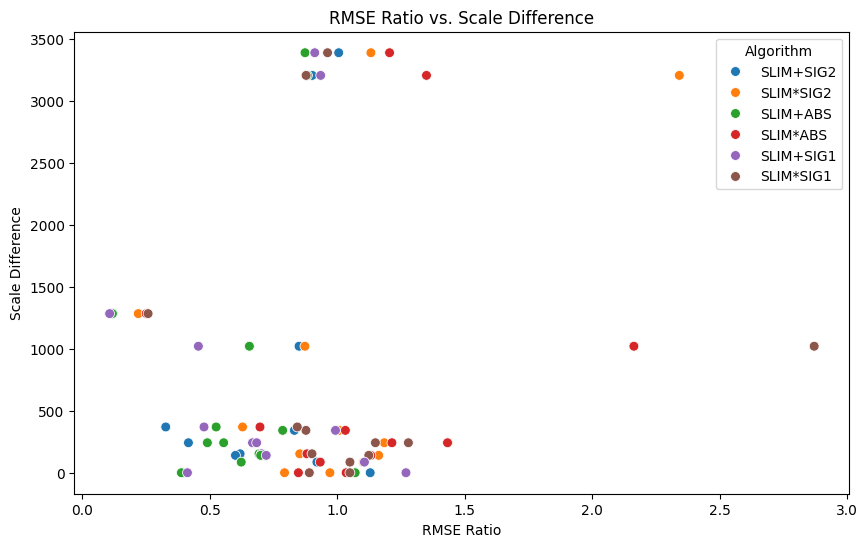

In [191]:
# Scatterplot the RMSE ratio against the scale difference
plt.figure(figsize=(10,6))
sns.scatterplot(data=df[df['Scale_Diff']<50], x='RMSE_Ratio', y='Scale_Std', hue='Algorithm', s=50)
plt.title('RMSE Ratio vs. Scale Difference')
plt.xlabel('RMSE Ratio')
plt.ylabel('Scale Difference')
plt.show()

#### Parameter comparison

In [71]:
def create_param_diff_df(dataset_names):
    all_params = []
    all_algorithms = set()

    for dataset in dataset_names:
        try:
            with open(f'params/{dataset}_scaled.pkl', 'rb') as f:
                params_scaled = pickle.load(f)
            
            with open(f'params/{dataset}.pkl', 'rb') as f:
                params_unscaled = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue

        all_algorithms.update(params_scaled.keys())

        for algo in params_scaled.keys():
            for param, value_scaled in params_scaled[algo].items():
                value_unscaled = params_unscaled[algo][param]
                all_params.append({
                    'Dataset': dataset,
                    'Algorithm': algo,
                    'Parameter': param,
                    'Scaled': value_scaled,
                    'Unscaled': value_unscaled,
                    'Difference': value_scaled - value_unscaled
                })

    df = pd.DataFrame(all_params)
    return df, list(all_algorithms)

# Funktion zur Formatierung der Unterschiede
def format_diff(x):
    return f"{x:+.2f}" if isinstance(x, (int, float)) else str(x)

# Erstellen des DataFrames
dataset_names = ['bike_sharing']
df, algorithms = create_param_diff_df(dataset_names)
df = df[~((df['Scaled'] == 0) & (df['Unscaled'] == 0))]

# Für jeden Datensatz und Algorithmus die Unterschiede anzeigen
for dataset in df['Dataset'].unique():
    print(f"\n## {dataset}")
    for algo in algorithms:
        print(f"\n**{algo}**")
        subset = df[(df['Dataset'] == dataset) & (df['Algorithm'] == algo)]
        if not subset.empty:
            diff_table = subset[['Parameter', 'Scaled', 'Unscaled', 'Difference']].copy()
            diff_table['Difference'] = diff_table['Difference'].apply(format_diff)
            print(diff_table.to_markdown(index=False, floatfmt=".2f"))
        else:
            print("Keine Daten verfügbar")


## bike_sharing

**SLIM*ABS**
| Parameter       |   Scaled |   Unscaled |   Difference |
|:----------------|---------:|-----------:|-------------:|
| p_inflate       |     0.40 |       0.60 |        -0.20 |
| max_depth       |    23.00 |      22.00 |         1.00 |
| init_depth      |     6.00 |      10.00 |        -4.00 |
| prob_const      |     0.30 |       0.20 |         0.10 |
| tournament_size |     2.00 |       2.00 |         0.00 |
| ms_upper        |     1.00 |       1.00 |         0.00 |

**SLIM+SIG2**
| Parameter       |   Scaled |   Unscaled |   Difference |
|:----------------|---------:|-----------:|-------------:|
| p_inflate       |     0.20 |       0.70 |        -0.50 |
| max_depth       |    24.00 |      20.00 |         4.00 |
| init_depth      |     6.00 |       7.00 |        -1.00 |
| prob_const      |     0.05 |       0.05 |         0.00 |
| tournament_size |     3.00 |       2.00 |         1.00 |
| ms_upper        |     1.00 |       0.00 |         1.00 |

**SLIM+SI

### Structure mutation

#### Ratio of the minimum means

In [284]:
dataset_names=[]
df_ratio = pd.DataFrame()
data_mins = []
for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)

for dataset in dataset_names:
    try: 
        with open('results/slim/'+dataset+'_scaled.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open('results/slim/'+dataset+'_scaled_strucmut.pkl', 'rb') as f:
            results_strucmut = pickle.load(f)
    except:
        print('Dataset not available:', dataset)
        continue        
    
    rmse_scaled = results_scaled['rmse']
    rmse_strucmut = results_strucmut['rmse']
    
    rmse_scaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_scaled.items()])
    rmse_strucmut_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_strucmut.items()])
    
    rmse_ratio = rmse_strucmut_means/rmse_scaled_means
    best_rmse_strucmut = rmse_strucmut_means.min()
    best_rmse_scaled = rmse_scaled_means.min()
    rmse_ratio_min = best_rmse_strucmut/best_rmse_scaled
    
    df_ratio_temp = pd.DataFrame(rmse_ratio, columns=[dataset])
    df_ratio = pd.concat([df_ratio, df_ratio_temp], axis=1)
    data_mins.append((dataset, best_rmse_strucmut, best_rmse_scaled, rmse_ratio_min))

# Change the index to results_scaled['rmse_compare'].keys()
df_ratio.index = list(results_scaled['rmse'].keys())
df_mins = pd.DataFrame(data_mins, columns=['Dataset', 'Best RMSE StrucMut', 'Best RMSE Scaled', 'Min Ratio'])

Dataset not available: parkinson_updrs


In [285]:
df_mins

,Dataset,Best RMSE StrucMut,Best RMSE Scaled,Min Ratio
0,airfoil,0.124125,0.126082,0.984475
1,bike_sharing,0.033563,0.056852,0.590357
2,bioav,0.310246,0.302402,1.025938
3,boston,0.116888,0.120730,0.968170
4,breast_cancer,0.286331,0.262721,1.089866
5,concrete_slump,0.277741,0.277617,1.000449
6,concrete_strength,0.120358,0.111478,1.079651
7,diabetes,0.183032,0.183919,0.995179
8,efficiency_cooling,0.092579,0.092796,0.997656
9,efficiency_heating,0.082668,0.080943,1.021316


#### Statistical significance

In [505]:
result = calculate_statistical_significance('scaled_strucmut', 'scaled', dataset_names)
# result.loc[('ld50',), :]
result.head(10)

Dataset nicht verfügbar: parkinson_updrs


Ratio Significance_RMSE Significance_Size
Dataset      Algorithm                                              
airfoil      SLIM*ABS   1.065535                 0               +++
             SLIM*SIG1  0.727903               +++                --
             SLIM*SIG2  0.929705                 +               +++
             SLIM+ABS   1.071246                 0               +++
             SLIM+SIG1  0.984613                 0                 0
             SLIM+SIG2  1.009724                 0               +++
bike_sharing SLIM*ABS   0.467964               +++               +++
             SLIM*SIG1  0.581464               +++               +++
             SLIM*SIG2  0.457831               +++               +++
             SLIM+ABS   0.536932               +++               +++

In [471]:
print(result['Significance_RMSE'].value_counts())
print(result['Significance_Size'].value_counts())

Significance_RMSE
0      42
+++    21
++      6
---     6
+       5
--      5
-       5
Name: count, dtype: int64
Significance_Size
+++    47
---    19
0      12
+       7
-       4
--      1
Name: count, dtype: int64


In [481]:
result_best = calculate_statistical_significance_best('scaled_strucmut', 'scaled', dataset_names)
result_best[result_best['Significance_RMSE'] != '0'].sort_values('Ratio')   

Dataset nicht verfügbar: parkinson_updrs


,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
bike_sharing,SLIM*ABS,SLIM+SIG1,0.590294,+++,+++
resid_build_sale_price,SLIM+SIG1,SLIM+SIG1,0.808284,+++,+++
istanbul,SLIM*ABS,SLIM+ABS,0.954733,++,---
concrete_strength,SLIM+SIG2,SLIM+SIG2,1.079743,---,-
breast_cancer,SLIM*ABS,SLIM+SIG2,1.089866,-,+++
ld50,SLIM*SIG1,SLIM+ABS,1.124255,---,---


In [482]:
result_best.sort_values('Ratio')

,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
bike_sharing,SLIM*ABS,SLIM+SIG1,0.590294,+++,+++
resid_build_sale_price,SLIM+SIG1,SLIM+SIG1,0.808284,+++,+++
istanbul,SLIM*ABS,SLIM+ABS,0.954733,++,---
boston,SLIM*ABS,SLIM+SIG2,0.968031,0,+++
airfoil,SLIM+SIG1,SLIM+SIG1,0.984613,0,0
diabetes,SLIM+SIG2,SLIM+SIG1,0.995196,0,---
efficiency_cooling,SLIM+SIG2,SLIM+SIG2,0.997246,0,0
forest_fires,SLIM+SIG1,SLIM+SIG2,0.998706,0,++
concrete_slump,SLIM*SIG2,SLIM+ABS,1.000287,0,---


In [397]:
main_prefix = 'scaled'
prefix_list = ['scaled_strucmut', 'scaled_mutxo', 'scaled_xo', 'scaled_xo_strucmut', 'scaled_mutxo_strucmut', 'scaled_xo_mutxo_strucmut']
rmse_results, size_results = compare_prefixes(main_prefix, prefix_list, dataset_names)

Dataset nicht verfügbar: parkinson_updrs


In [454]:
counts_df = pd.DataFrame()
for column in rmse_results.columns:
    value_counts_df = rmse_results[column].value_counts()
    counts_df[column] = value_counts_df
counts_df = counts_df.fillna(0).astype(int)

In [457]:
counts_df.sort_index()

,scaled_strucmut,scaled_mutxo,scaled_xo,scaled_xo_strucmut,scaled_mutxo_strucmut,scaled_xo_mutxo_strucmut
scaled_strucmut,,,,,,
+,5,6,7,6,6,9
++,6,4,8,6,4,2
+++,21,2,14,19,17,21
-,5,4,7,9,2,7
--,5,6,3,9,5,5
---,6,15,14,11,6,10
0,42,53,37,30,50,36


In [438]:
# Get the rmses 
prefix_list = ['scaled_strucmut', 'scaled_mutxo', 'scaled_xo', 'scaled_xo_strucmut', 'scaled_mutxo_strucmut', 'scaled_xo_mutxo_strucmut']
means_dataset = create_rmse_means_dataset(prefix_list, dataset_names)

In [465]:
for dataset, min_id in zip(means_dataset.columns, means_dataset.idxmin()):
    with open(f'results/slim/{dataset}_{min_id[0]}.pkl', 'rb') as f:
        rmse_compare = pickle.load(f)
        size = rmse_compare['size'][min_id[1]]
        rmse_compare = rmse_compare['rmse_compare'][min_id[1]]
    with open(f'results/slim/{dataset}_scaled.pkl', 'rb') as f:
        results_base = pickle.load(f)
        rmse_compare_base = results_base['rmse_compare']
        best_scaled_algo = min(rmse_compare_base, key=lambda k: np.mean(rmse_compare_base[k]))
        rmse_compare_base = rmse_compare_base[best_scaled_algo]
        size_base = results_base['size'][min_id[1]]
        
    # Wilcoxon-Test durchführen
    d_rmse = np.round(np.array(rmse_compare) - np.array(rmse_compare_base), decimals=8)
    statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
    
    rmse_mean = np.mean(rmse_compare)
    rmse_base_mean = np.mean(rmse_compare_base)
    ratio = rmse_mean / rmse_base_mean
    
    significant = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'NS'))
    significance = '0' if not (p_value < 0.05) else ('-' if ratio > 1 else '+')
    
    print(f"{dataset}: {min_id[0]} ({min_id[1]}) vs. scaled ({best_scaled_algo}) - Ratio: {ratio:.2f}, Significance: {significant} ({significance}), Size: {np.mean(size):.2f} vs. {np.mean(size_base):.2f}")

airfoil: scaled_strucmut (SLIM+SIG1) vs. scaled (SLIM+SIG1) - Ratio: 0.98, Significance: NS (0), Size: 309.70 vs. 290.46
bike_sharing: scaled_xo_mutxo_strucmut (SLIM*SIG1) vs. scaled (SLIM+SIG1) - Ratio: 0.46, Significance: *** (+), Size: 71.08 vs. 209.26
bioav: scaled_xo (SLIM+ABS) vs. scaled (SLIM*ABS) - Ratio: 1.00, Significance: NS (0), Size: 79.38 vs. 116.24
boston: scaled_xo_strucmut (SLIM+SIG1) vs. scaled (SLIM+SIG2) - Ratio: 0.93, Significance: * (+), Size: 115.50 vs. 207.90
breast_cancer: scaled_xo_mutxo_strucmut (SLIM+SIG1) vs. scaled (SLIM+SIG2) - Ratio: 1.01, Significance: NS (0), Size: 155.92 vs. 304.26
concrete_slump: scaled_xo_mutxo_strucmut (SLIM+ABS) vs. scaled (SLIM+ABS) - Ratio: 0.98, Significance: NS (0), Size: 233.18 vs. 222.12
concrete_strength: scaled_xo (SLIM*SIG1) vs. scaled (SLIM+SIG2) - Ratio: 1.02, Significance: NS (0), Size: 268.26 vs. 309.44
diabetes: scaled_xo (SLIM+ABS) vs. scaled (SLIM+SIG1) - Ratio: 0.96, Significance: *** (+), Size: 233.88 vs. 174.12


#### Parameters

In [495]:
with open('params/'+'airfoil_scaled_mutxo_strucmut.pkl', 'rb') as f:
    params = pickle.load(f)
    
params

{'SLIM+SIG2': {'p_inflate': 0.6,
  'max_depth': 22,
  'init_depth': 8,
  'prob_const': 0.3,
  'prob_replace': 0.0,
  'p_prune': 0.1,
  'p_xo': 0.1,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*SIG2': {'p_inflate': 0.2,
  'max_depth': 24,
  'init_depth': 10,
  'prob_const': 0.3,
  'prob_replace': 0.015,
  'p_prune': 0.2,
  'p_xo': 0.2,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM+ABS': {'p_inflate': 0.1,
  'max_depth': 21,
  'init_depth': 8,
  'prob_const': 0.15,
  'prob_replace': 0.015,
  'p_prune': 0.3,
  'p_xo': 0.2,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 2,
  'ms_lower': 0,
  'ms_upper': 0},
 'SLIM*ABS': {'p_inflate': 0.2,
  'max_depth': 24,
  'init_depth': 8,
  'prob_const': 0.2,
  'prob_replace': 0.01,
  'p_prune': 0.3,
  'p_xo': 0.4,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 

In [498]:
msu_results = {}
msl_results = {}

for file_name in os.listdir('params'):
    with open('params/'+file_name, 'rb') as f:
        params = pickle.load(f)
    for algo in params.keys():
        ms_upper, ms_lower = params[algo]['ms_upper'], params[algo]['ms_lower']
        if ms_upper not in msu_results:
            msu_results[ms_upper] = 0
        if ms_lower not in msl_results:
            msl_results[ms_lower] = 0
        if ms_upper == 0:
            print(f'{file_name} - {algo}')
        msu_results[ms_upper] += 1
        msl_results[ms_lower] += 1

airfoil_scaled_mutxo_strucmut.pkl - SLIM+ABS
airfoil_scaled_strucmut.pkl - SLIM+SIG2
airfoil_scaled_strucmut.pkl - SLIM*SIG2
airfoil_scaled_strucmut.pkl - SLIM+ABS
airfoil_scaled_strucmut.pkl - SLIM*ABS
airfoil_scaled_xo.pkl - SLIM*SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM*SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+ABS
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+SIG1
airfoil_scaled_xo_strucmut.pkl - SLIM+SIG2
airfoil_scaled_xo_strucmut.pkl - SLIM*SIG2
airfoil_scaled_xo_strucmut.pkl - SLIM*ABS
airfoil_scaled_xo_strucmut.pkl - SLIM*SIG1
bike_sharing.pkl - SLIM+SIG2
bike_sharing.pkl - SLIM*SIG2
bike_sharing.pkl - SLIM+SIG1
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM+SIG2
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM*SIG2
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM+SIG1
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM*SIG1
bike_sharing_scaled_strucmut.pkl - SLIM+ABS
bike_sharing_scaled_xo.pkl - SLIM+SIG2
bike_sharing_scaled_xo.

In [488]:
msu_results

{1: 692, 0: 160}

In [484]:
params

{'SLIM+SIG2': {'p_inflate': 0.6,
  'max_depth': 24,
  'init_depth': 5,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*SIG2': {'p_inflate': 0.2,
  'max_depth': 22,
  'init_depth': 7,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM+ABS': {'p_inflate': 0.5,
  'max_depth': 24,
  'init_depth': 8,
  'prob_const': 0.05,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*ABS': {'p_inflate': 0.4,
  'max_depth': 19,
  'init_depth': 7,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLI

In [506]:
with open('results/slim/airfoil_scaled.pkl', 'rb') as f:
    results = pickle.load(f)   

In [507]:
results

{'rmse': {'SLIM+SIG2': [0.12821269035339355,
   0.13759015500545502,
   0.13613857328891754,
   0.12858453392982483,
   0.13378199934959412,
   0.1387992799282074,
   0.14728321135044098,
   0.12079181522130966,
   0.16848109662532806,
   0.1271216720342636,
   0.13000483810901642,
   0.11772646009922028,
   0.13450556993484497,
   0.13266229629516602,
   0.13186195492744446,
   0.12456110119819641,
   0.11951985955238342,
   0.12339513003826141,
   0.1189185306429863,
   0.13154426217079163,
   0.1327536255121231,
   0.1303754448890686,
   0.13240988552570343,
   0.14288198947906494,
   0.13496920466423035,
   0.14560213685035706,
   0.14564943313598633,
   0.12602542340755463,
   0.1544836312532425,
   0.1214199811220169,
   0.13092602789402008,
   0.11629363894462585,
   0.14091384410858154,
   0.13223685324192047,
   0.12334559857845306,
   0.13722684979438782,
   0.13244910538196564,
   0.13308165967464447,
   0.12476075440645218,
   0.12386224418878555,
   0.1374443918466568,
   